MIT License

Copyright (c) 2023 Pavel Shibanov [https://blog.experienced.dev/](https://blog.experienced.dev/?utm_source=notebooks)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

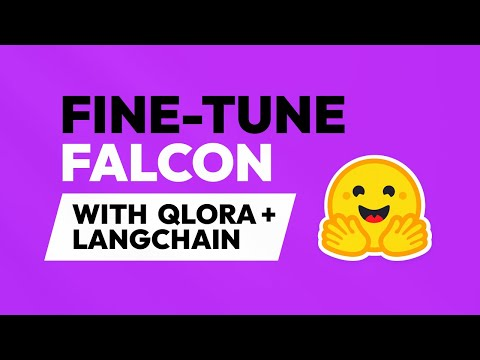

In [45]:
from IPython.display import YouTubeVideo

YouTubeVideo("X4-2zw5QLns", width="560", height="315")

In [ ]:
%env PIP_QUIET=1

In [ ]:
%pip install python-dotenv==1.0.0

In [ ]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [ ]:
# @markdown Download the [vast.ai](https://cloud.vast.ai/?ref=71973) CLI
import os
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/vast-ai/vast-python/638e9bc/vast.py", "vast"
)
os.chmod("vast", 0o755)

In [ ]:
# @markdown Helper to extract dictionaries from
# @markdown [vast.ai CLI](https://cloud.vast.ai/?ref=71973)
import subprocess
import json


def vast_ai_cmd(args=None):
    if not args:
        args = ["--help"]
    cmd = ["./vast"]
    cmd += args
    result = subprocess.run(cmd, capture_output=True)
    if result.stderr:
        print(result.stderr)
    output = result.stdout.decode()

    if "--raw" in cmd:
        try:
            data = json.loads(output)
            return data
        except json.JSONDecodeError as e:
            print(f"An error occurred: {str(e)}")
    else:
        print(output)


vast_ai_cmd()

In [ ]:
# @markdown vast.ai API key. You can obtain one at [vast.ai](https://cloud.vast.ai/?ref=71973)
import os
from IPython.display import display, Markdown

VAST_AI_API_KEY = os.getenv("VAST_AI_API_KEY", "your_vast_ai_api_key")
if VAST_AI_API_KEY == "your_vast_ai_api_key":
    display(
        Markdown(
            "It appears that you don't have a vast.ai API key. You can obtain one at [vast.ai](https://cloud.vast.ai/?ref=71973)"
        )
    )
    raise AssertionError("Missing vast.ai API key")

vast_ai_cmd(["set", "api-key", VAST_AI_API_KEY])

In [ ]:
# @markdown Searching for suitable hardware to run fine-tune falcon-7b with QLoRa.
import pandas as pd

raw_offers = vast_ai_cmd(
    [
        "search",
        "offers",
        "--raw",
        "reliability > 0.9 cuda_vers >= 11.7 num_gpus = 1 gpu_ram >= 24 inet_down >= 700 inet_up >=500 disk_space >= 50",
        "-o",
        "dph",
    ]
)

offers_count = len(raw_offers)
if offers_count:
    print(f"{offers_count=}")
    offers = pd.DataFrame.from_dict(raw_offers)
else:
    raise AssertionError("No offers, change search query")
offers[
    [
        "id",
        "dph_total",
        "inet_down",
        "inet_up",
        "cuda_max_good",
        "num_gpus",
        "gpu_name",
        "gpu_ram",
        "cpu_ram",
        "disk_space",
    ]
].head()

In [ ]:
# @markdown Selecting a hardware.
selected_id = 0
selected = offers.iloc[selected_id]
selected.id, selected.dph_total

In [ ]:
res = vast_ai_cmd(
    [
        "create",
        "instance",
        "--raw",
        str(selected.id),
        "--onstart-cmd",
        "env | grep _ >> /etc/environment; echo 'starting up'",
        "--jupyter",
        "--jupyter-lab",
        "--disk",
        "50",
        "--image",
        "pytorch/pytorch:2.0.1-cuda11.7-cudnn8-devel",
    ]
)
instance_id = res["new_contract"]
instance_id

In [ ]:
# @markdown Waiting for instance to become running.
import time
from IPython.display import clear_output

is_running = False
while not is_running:
    instances = vast_ai_cmd(["show", "instances", "--raw"])
    instance = next((i for i in instances if i["id"] == instance_id), None)
    is_running = instance["actual_status"] == "running"
    clear_output(wait=True)
    print(instance)
    time.sleep(3)

In [ ]:
vast_ai_cmd(["logs", str(instance_id)])

In [ ]:
instances = vast_ai_cmd(["show", "instances", "--raw"])
instance = next((i for i in instances if i["id"] == instance_id), None)
is_running = instance["actual_status"] == "running"
print(instance)
jupyter_url = f"https://jupyter.vast.ai/jm/{instance['ssh_idx']}/{instance['ssh_port']}"
print(f"{jupyter_url}?token={instance['jupyter_token']}")

In [ ]:
import os
import json
import urllib.parse
import requests

notebook = "2023_07_15_falcon_finetune_qlora_langchain.ipynb"
token = instance["jupyter_token"]
file_path = notebook
resource_dst_path = notebook
dst_path = urllib.parse.quote(resource_dst_path)
dst_url = f"{jupyter_url}/api/contents/{dst_path}"
file_name = file_path[1 + file_path.rfind(os.sep) :]
headers = {"Authorization": f"token {token}"}

res = requests.get(
    f"https://raw.githubusercontent.com/experienced-dev/notebooks/master/{notebook}"
)

body = json.dumps(
    {
        "content": res.json(),
        "name": file_name,
        "path": resource_dst_path,
        "format": "json",
        "type": "notebook",
    }
)

response = requests.put(dst_url, data=body, headers=headers, verify=True)

print(f"{jupyter_url}/lab/tree/{notebook}?token={token}")

In [ ]:
# @markdown Destroy the instance.
vast_ai_cmd(["destroy", "instance", str(instance_id)])